In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import gsw
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context("talk")

In [3]:
# Load Data
data = pd.read_csv("data_clean.csv")
data = data[
    [
        "Station",
        "Depth",
        "lon",
        "lat",
        "T",
        "S",
        "P",
        "O2",
        "sigma0",
        "rho",
        "DIC",
        "DIP",
        "NO3",
        "NO2"
    ]
]

In [4]:
data = data[(data.Station != 47)&
           (data.Station != 58)]

# Calculate AOU
SA = gsw.SA_from_SP(data["S"], data["P"], data["lon"], data["lat"])
PT = gsw.pt0_from_t(SA, data["T"], data["P"])
O2sat = gsw.O2sol_SP_pt(data["S"], PT)
AOU = O2sat - data["O2"]
data["AOU"] = AOU
data["DIN"] = data["NO3"] + data["NO2"]

In [5]:
oxycline = data[(data['Depth'] < 200) &
             (data.O2 > 2) &
             (data.O2 < 190)]

oxycline = oxycline.dropna()

In [6]:
np.gradient(data.O2)

array([-6.87 , -7.58 , -8.18 , ..., -1.625, -0.05 , -0.01 ])

In [7]:
# regress O2, AOU, DIC, and DIN on phosphate (DIP) to calculate oxycline C:N:P and AOU:P
xx = sm.add_constant(oxycline["DIP"])
# Huber's t robust regression assigns varying weight values to outliers based on the
# predicted residual values, reduces the contribution of outliers to the regression,
# and increases the accuracy of slope value (Huber, 1973).
rO2 = sm.RLM(oxycline["O2"], xx, M=sm.robust.norms.HuberT()).fit()
rAOU = sm.RLM(oxycline["AOU"], xx, M=sm.robust.norms.HuberT()).fit()
rC = sm.RLM(oxycline["DIC"], xx, M=sm.robust.norms.HuberT()).fit()
rN = sm.RLM(oxycline["DIN"], xx, M=sm.robust.norms.HuberT()).fit()

In [8]:
rO2.params

const    217.395139
DIP      -90.489361
dtype: float64

In [9]:
# plot regressions quickly
def quickplot(xvar, yvar, regressionparams):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(oxycline[xvar], oxycline[yvar],
              alpha = 0.1)
    xfit = np.linspace(oxycline[xvar].min(), oxycline[xvar].max())
    ax.plot(xfit, xfit * regressionparams[1] + regressionparams[0], color="k")
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)
    plt.tight_layout()
    plt.show()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7557/2100482114.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(xfit, xfit * regressionparams[1] + regressionparams[0], color="k")


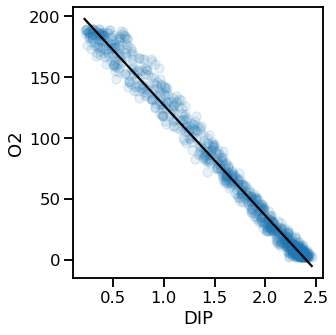

In [10]:
quickplot("DIP", "O2", rO2.params)

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7557/2100482114.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(xfit, xfit * regressionparams[1] + regressionparams[0], color="k")


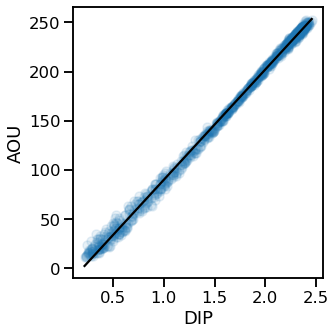

In [11]:
quickplot("DIP", "AOU", rAOU.params)

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7557/2100482114.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(xfit, xfit * regressionparams[1] + regressionparams[0], color="k")


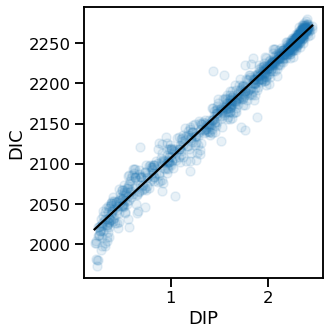

In [12]:
quickplot("DIP", "DIC", rC.params)

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7557/2100482114.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(xfit, xfit * regressionparams[1] + regressionparams[0], color="k")


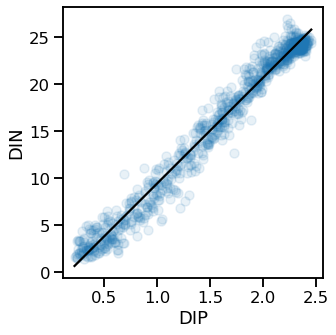

In [13]:
quickplot("DIP", "DIN", rN.params)

In [14]:
# Calculate respiration quotient and Cox (oxidation state of organic carbon)
"""
this comes from calculating Cox from:
1. CaHbOc, which gives us a*Cox = 2c-b
2. Balancing the respiration reaction CaHbOc -> a CO2 + yH2O, which phrases 2c - b (and thus Cox) in terms of things we can measure:
2c - b = 4a - 4r
...where r = AOU:P and a = DIC:P, calculated from data in the oxycline
"""
Cox1 = round(
    4 - 4 * (rAOU.params[1] - 2 * rN.params[1]) / rC.params[1], 2
)  # Cox with nitrification = 4 - 4*(AOU:P - N:P)/C:P
Cox2 = round(
    4 - 4 * (rAOU.params[1]) / rC.params[1], 2
)  # Cox with no nitrification = 4 - 4*AOU:P/C:P

# Print Results
text1 = "RLS C:N:P is {}+-{} : {}+-{} : 1 (se)".format(
    round(rC.params[1], 3),
    round(rC.bse[1], 3),
    round(rN.params[1], 3),
    round(rN.bse[1], 3),
)
text2 = "RLS AOU:P is {}+-{}".format(round(rAOU.params[1], 3), round(rAOU.bse[1], 3))
# text3 should match values in Table S2
text3 = "RLS Cox calculated with AOU:P is {}, and {} with no nitrification".format(
    Cox1, Cox2
)


print(text1, text2, text3, sep="\n")

RLS C:N:P is 113.125+-0.467 : 11.232+-0.058 : 1 (se)
RLS AOU:P is 112.198+-0.178
RLS Cox calculated with AOU:P is 0.83, and 0.03 with no nitrification


/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7557/540622294.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  4 - 4 * (rAOU.params[1] - 2 * rN.params[1]) / rC.params[1], 2
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7557/540622294.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  4 - 4 * (rAOU.params[1]) / rC.params[1], 2
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7557/540622294.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To 

In [15]:
# Extract values and standard errors
A = rAOU.params[1]
sigma_A = rAOU.bse[1]

N = rN.params[1]
sigma_N = rN.bse[1]

C = rC.params[1]
sigma_C = rC.bse[1]

# Compute Cox1
Cox1 = 4 - 4 * (A - 2 * N) / C

# Compute partial derivatives
df_dA = -4 / C
df_dN = 8 / C
df_dC = 4 * (A - 2 * N) / (C ** 2)

# Error propagation
sigma_Cox1 = np.sqrt(
    (df_dA * sigma_A) ** 2 +
    (df_dN * sigma_N) ** 2 +
    (df_dC * sigma_C) ** 2
)

# Output results
print("Cox1 = {:.2f} ± {:.2f}".format(Cox1, sigma_Cox1))


Cox1 = 0.83 ± 0.02


/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7557/1698287331.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  A = rAOU.params[1]
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7557/1698287331.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma_A = rAOU.bse[1]
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7557/1698287331.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  N = rN.params[